In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import seaborn as sns
import os
import os.path as osp
import sys
import pickle
import joblib
from collections import Counter
from itertools import product
import torch
import pdb
import random
import tables
from sklearn.linear_model import LogisticRegression, LinearRegression
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, average_precision_score,\
balanced_accuracy_score
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.calibration import CalibratedClassifierCV
import wandb
from wandb.lightgbm import wandb_callback, log_summary
from dill.source import getsource
from dill import detect
import functools
from copy import deepcopy

### set the seeds and change to current directory + set the output directory

In [3]:
SEED=90210
np.random.seed(SEED)
os.environ['USER_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/'
os.environ['OUT_PATH']='/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory'

In [4]:
os.chdir('/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/')
from AnalysisFuncs import trainEvalModel, trainHardPseudo, secondStageDataGen, getClippedProbs
from AnalysisFuncs import saveFile, loadFile, plotCalibrationPlots

In [5]:
%reload_ext autoreload
%autoreload 2

### Create function to pickle functions

In [6]:
def function_to_string(fn):
    return getsource(detect.code(fn)) 

In [7]:
processed_data_path=osp.join(os.environ.get('OUT_PATH'), 'stop_and_frisk')

In [8]:
calibrate_method='sigmoid'
test_X = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'), '/test_X.npy')

In [9]:
test_idxs = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'),'/test_idxs.npy')
cal_idxs = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'),'/cal_idxs.npy')
train_idxs = loadFile(processed_data_path, '/train_idxs.npy')
val_idxs = loadFile(processed_data_path, '/val_idxs.npy')
assert len(np.intersect1d(train_idxs, val_idxs))==0
assert len(np.intersect1d(test_idxs, val_idxs))==0
assert len(np.intersect1d(train_idxs, test_idxs))==0
tr=len(train_idxs)
v=len(val_idxs)
t=len(test_idxs)
cal = len(cal_idxs)
print(f"train %:{tr*100/(tr+v+t+cal):.2f}, val %:{v*100/(tr+v+t+cal):.2f}, cal %:{cal*100/(tr+v+t+cal):.2f}, test %:{t*100/(tr+v+t+cal):.2f}")

train %:45.00, val %:5.00, cal %:25.00, test %:25.00


In [10]:
calibrated_p_T = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_T'), '/probs.npy')
assert len(calibrated_p_T)==len(test_idxs)
calibrated_p_D_T1 = loadFile(osp.join(processed_data_path, calibrate_method, 'probs_D|T'), '/probs.npy')
assert len(calibrated_p_D_T1)==len(test_idxs)

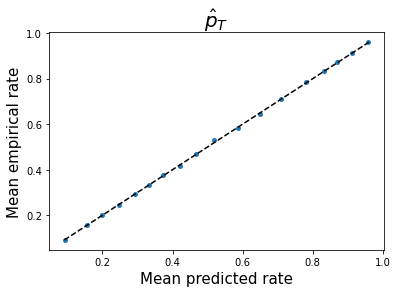

In [14]:
# check that these are indeed the calibrated probabilities 
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_T = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'), '/test_y_T.npy')
plotCalibrationPlots(calibrated_p_T, test_y_T, None, 'T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()

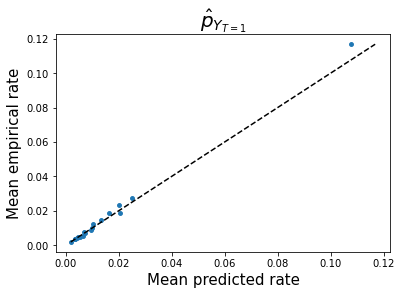

In [15]:
fig1,ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
test_y_D_given_T = loadFile(osp.join(processed_data_path, calibrate_method, 'after_cal'), '/test_y_D_given_T.npy')
plotCalibrationPlots(calibrated_p_D_T1[test_y_T==1], test_y_D_given_T, None, 'D|T', ax1, ax2, n_bins=20)
fig1.show()
fig2.show()
plt.close()

In [10]:
train_second_stage, test_second_stage, cal_second_stage = secondStageDataGen(test_idxs,
                calibrated_p_T.copy(), calibrated_p_D_T1.copy(), train_size=0.5,
                cal_size=0.5)
assert np.isnan(train_second_stage['D'][train_second_stage['T']==0]).all()
assert np.isnan(test_second_stage['D'][test_second_stage['T']==0]).all()
assert not np.isnan(train_second_stage['D'][train_second_stage['T']==1]).any()
assert not np.isnan(test_second_stage['D'][test_second_stage['T']==1]).any()

In [11]:
np.isnan(train_second_stage['D'][train_second_stage['T']==1]).all()

False

In [12]:
train_second_stage

{'idxs': array([361753, 527995,  14143, ..., 239397, 528452, 175748]),
 'T': array([1, 0, 0, ..., 1, 1, 1]),
 'D': array([ 0., nan, nan, ...,  0.,  0.,  0.]),
 'D_and_T': array([0, 0, 0, ..., 0, 0, 0])}

In [13]:
test_X_copy=test_X.copy()
train_second_stage['X_T'] = test_X_copy[train_second_stage['idxs'],:]
train_second_stage['X_D_T1'] = test_X_copy[train_second_stage['idxs'],:][train_second_stage['T']==1,:]
train_second_stage['D_T1'] = train_second_stage['D'][train_second_stage['T']==1].astype(int)

test_second_stage['X_T'] = test_X_copy[test_second_stage['idxs'],:]
test_second_stage['X_D_T1'] = test_X_copy[test_second_stage['idxs']][test_second_stage['T']==1,:]
test_second_stage['D_T1'] = test_second_stage['D'][test_second_stage['T']==1].astype(int)

cal_second_stage['X_T'] = test_X_copy[cal_second_stage['idxs'],:]
cal_second_stage['X_D_T1'] = test_X_copy[cal_second_stage['idxs']][cal_second_stage['T']==1,:]
cal_second_stage['D_T1'] = cal_second_stage['D'][cal_second_stage['T']==1].astype(int)

In [14]:
print("for test train set \n")
print(f"T % :{len(train_second_stage['T'][train_second_stage['T']==1])/len(train_second_stage['T'])}")
print(f"D_T1 % :{len(train_second_stage['D_T1'][train_second_stage['D_T1']==1])/len(train_second_stage['D_T1'])}")
print(f"D_and_T % :{len(train_second_stage['D_and_T'][train_second_stage['D_and_T']==1])/len(train_second_stage['T'])}")
print("for test test set \n")
print(f"T % :{len(test_second_stage['T'][test_second_stage['T']==1])/len(test_second_stage['T'])}")
print(f"D_T1 % :{len(test_second_stage['D_T1'][test_second_stage['D_T1']==1])/len(test_second_stage['D_T1'])}")
print(f"D_and_T % :{len(test_second_stage['D_and_T'][test_second_stage['D_and_T']==1])/len(test_second_stage['T'])}")

print("for cal set \n")
print(f"T % :{len(cal_second_stage['T'][cal_second_stage['T']==1])/len(cal_second_stage['T'])}")
print(f"D_T1 % :{len(cal_second_stage['D_T1'][cal_second_stage['D_T1']==1])/len(cal_second_stage['D_T1'])}")
print(f"D_and_T % :{len(cal_second_stage['D_and_T'][cal_second_stage['D_and_T']==1])/len(cal_second_stage['T'])}")

for test train set 

T % :0.5635006416397057
D_T1 % :0.01961073618844782
D_and_T % :0.011050662425217345
for test test set 

T % :0.5627250249425237
D_T1 % :0.01970835742275326
D_and_T % :0.011090385922295002
for cal set 

T % :0.5651542098642259
D_T1 % :0.020199306648245513
D_and_T % :0.011415723188594398


In [15]:
saveFile(osp.join(processed_data_path,'secondStage'), train_second_stage, 'train_second_stage.pkl')
saveFile(osp.join(processed_data_path,'secondStage'), test_second_stage, 'test_second_stage.pkl')
saveFile(osp.join(processed_data_path,'secondStage'), cal_second_stage, 'cal_second_stage.pkl')

In [16]:
# load the best params as pickle if they exist , if not use the default settings
random_state=0
bst_params_T_LGBM={'random_state': random_state, 
                  }
LGBM_T = LGBMClassifier(**bst_params_T_LGBM)
bst_params_D_given_T_LGBM = {'bagging_fraction': 0.9834006751148752, 
             'feature_fraction': 0.7609241608750359, 'max_depth': 7, 'min_child_samples': 50}
LGBM_D_given_T = LGBMClassifier(**bst_params_D_given_T_LGBM)
LGBM_D_given_T_ipw = LGBMClassifier(**bst_params_D_given_T_LGBM)
bst_params_D_and_T_LGBM={'random_state': random_state, 
                  }
LGBM_D_and_T = LGBMClassifier(**bst_params_D_and_T_LGBM)
calibrate_method='sigmoid'

In [17]:
model_descr="predicting T using LGBM for second stage"
LGBM_T, test_proba_LGBM_T = trainEvalModel(LGBM_T, train_second_stage['X_T'], train_second_stage['T'], 
                                           test_second_stage['X_T'], test_second_stage['T'], 
                                       model_descr, calibrate=True, calibrate_method=calibrate_method)

AUC score :predicting T using LGBM for second stage: 0.828
AUPR score :predicting T using LGBM for second stage: 0.861


In [18]:
#save models
saveFile(osp.join(processed_data_path, 'secondStage','predict_T'), LGBM_T, 'LGBM_T.pkl')

In [19]:
model_descr="predicting D|T using LGBM for second stage"
LGBM_D_given_T, test_proba_LGBM_D_given_T = trainEvalModel(LGBM_D_given_T, train_second_stage['X_D_T1'], 
                    train_second_stage['D_T1'], test_second_stage['X_D_T1'], 
                                            test_second_stage['D_T1'],
                                            model_descr, calibrate=True, calibrate_method=calibrate_method)

[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. C

In [20]:
saveFile(osp.join(processed_data_path, 'secondStage', 'predict_D_given_T'), LGBM_D_given_T, 'LGBM_D_given_T.pkl')

In [21]:
model_descr="predicting D,T using LGBM for second stage"
LGBM_D_and_T, test_proba_LGBM_D_and_T = trainEvalModel(LGBM_D_and_T, train_second_stage['X_T'], 
                    train_second_stage['D_and_T'], test_second_stage['X_T'],
                                        test_second_stage['D_and_T'],
                                        model_descr, calibrate=True, calibrate_method=calibrate_method)

AUC score :predicting D,T using LGBM for second stage: 0.838
AUPR score :predicting D,T using LGBM for second stage: 0.082


In [22]:
saveFile(osp.join(processed_data_path, 'secondStage', 'predict_D_and_T'), LGBM_D_and_T, 'LGBM_D_and_T.pkl')

calibrating by bins using cal data
val max:6916, val min:6915
 number of bins in test :20
calibrated_preds
0.106854    0.096431
0.156449    0.149006
0.204020    0.199652
0.255205    0.240492
0.287305    0.284597
0.330393    0.336009
0.370065    0.374207
0.413534    0.423766
0.478456    0.463217
0.524291    0.515793
0.586466    0.585298
0.646038    0.654223
0.706622    0.718586
0.789588    0.782010
0.836611    0.833542
0.877820    0.870364
0.903412    0.903237
0.922209    0.925345
0.942597    0.946658
0.965153    0.971285
Name: ground_truth, dtype: float64
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006

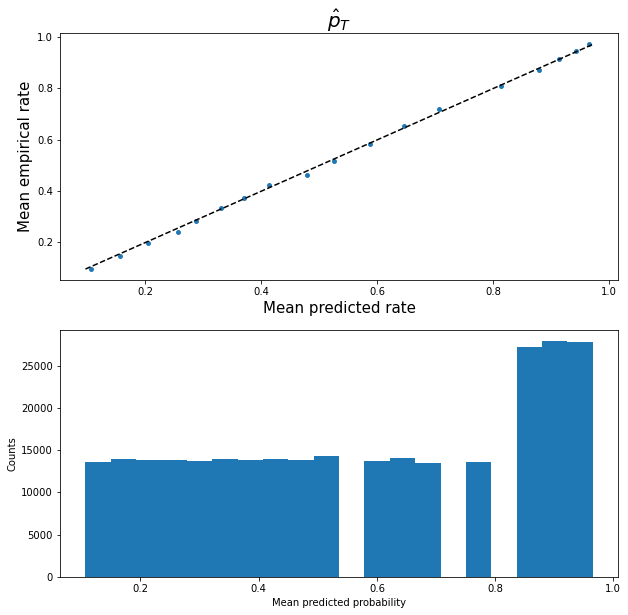

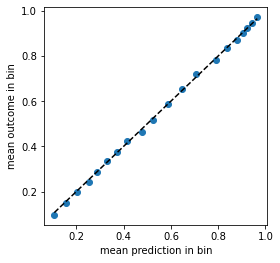

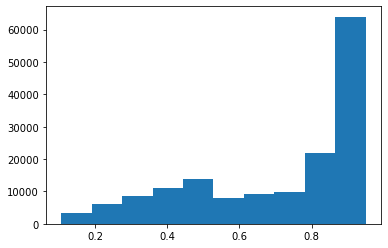

In [23]:
model_descr="predicting D|T_IPW using LGBM"
train_X_D_given_T_probs_LGBM, train_cross_val_X_ipw = getClippedProbs(LGBM_T, 
    train_second_stage['X_T'].copy(), train_second_stage['T'].copy(),
    cal_X=cal_second_stage['X_T'].copy(), cal_y_T=cal_second_stage['T'].copy())
# train_X_D_given_T_probs_LGBM, train_cross_val_X_ipw = getClippedProbs(LGBM_T, 
#     train_second_stage['X_T'].copy(), train_second_stage['T'].copy())
np.testing.assert_array_equal(train_cross_val_X_ipw, train_second_stage['X_D_T1'])
LGBM_D_given_T_ipw, test_proba_LGBM_D_given_T_ipw = trainEvalModel(LGBM_D_given_T_ipw,
                    train_second_stage['X_D_T1'].copy(), 
                    train_second_stage['D_T1'].copy(), test_second_stage['X_D_T1'].copy(),
                    test_second_stage['D_T1'].copy(), model_descr,
                    calibrate=True, calibrate_method=calibrate_method,
                    sample_weight=1/train_X_D_given_T_probs_LGBM.copy())

In [24]:
saveFile(osp.join(processed_data_path, 'secondStage', 'predict_D_given_T_ipw'), LGBM_D_given_T_ipw, 'LGBM_D_given_T_ipw.pkl')

#### Hard PseudoLabels

In [25]:
random_state=0
bst_params_D_pseudo_LGBM = bst_params_D_given_T_LGBM
LGBM_D_pseudo = LGBMClassifier(**bst_params_D_pseudo_LGBM)

In [26]:
LGBM_D_pseudo, test_probs_D_pseudo_LGBM = trainHardPseudo(deepcopy(LGBM_D_given_T), None, None, None,
        train_second_stage['X_T'], None, deepcopy(LGBM_D_given_T), test_second_stage['X_D_T1'].copy(),
                                                          test_second_stage['D_T1'].copy(), 
        model_descr="LGBM with hard pseudo labels for second stage", calibrate=False, 
        train_y_D=train_second_stage['D'].copy())


Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
Finished loading model, total used 100 iterations
no val data was passed
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_fraction is set=0.7609241608750359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7609241608750359
[LightGBM] [Warning] bagging_fraction is set=0.9834006751148752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834006751148752
[LightGBM] [Warning] feature_

In [27]:
train_second_stage['D'][train_second_stage['D']==np.nan]

array([], dtype=float64)

In [28]:
train_second_stage['D'][train_second_stage['T']==0]

array([nan, nan, nan, ..., nan, nan, nan])

In [29]:
saveFile(osp.join(processed_data_path,'secondStage', 'predict_D_pseudo'), LGBM_D_pseudo, 'LGBM_D_pseudo.pkl')

In [30]:
processed_data_path

'/share/pierson/selective_labels_data/hirid_data_analysis/richras_dir/learning_from_doctor_and_patient/output_directory/stop_and_frisk'